# IPL 2024 RCB Vs DC Analysis Using Python

In [1]:
import pandas as pd
deliveries_df = pd. read_csv(r"/Users/tanishqsharma/Desktop/Python Projects/IPL 2024 RCB vs DC/innings_deliveries.csv")

print(deliveries_df.head())

                          team  over        batter    bowler   non_striker  \
0  Royal Challengers Bengaluru     0       V Kohli  I Sharma  F du Plessis   
1  Royal Challengers Bengaluru     0       V Kohli  I Sharma  F du Plessis   
2  Royal Challengers Bengaluru     0  F du Plessis  I Sharma       V Kohli   
3  Royal Challengers Bengaluru     0       V Kohli  I Sharma  F du Plessis   
4  Royal Challengers Bengaluru     0       V Kohli  I Sharma  F du Plessis   

   runs_batter  runs_extras  runs_total player_out wicket_kind fielders  
0            0            0           0        NaN         NaN       []  
1            1            0           1        NaN         NaN       []  
2            1            0           1        NaN         NaN       []  
3            0            0           0        NaN         NaN       []  
4            2            0           2        NaN         NaN       []  


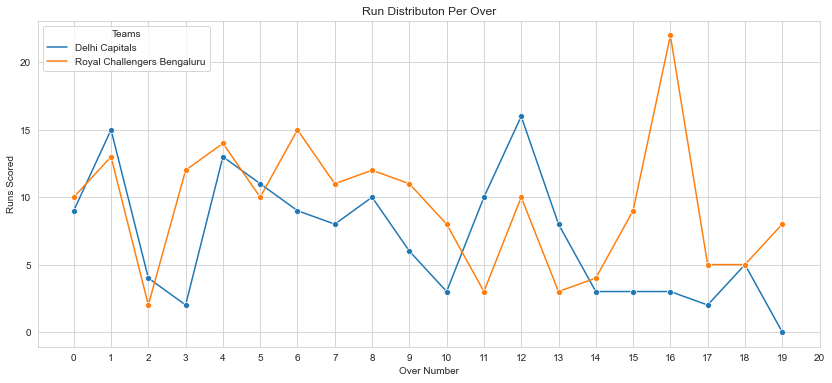

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# data prepration for run distribution per over
run_distribution = deliveries_df.groupby(['team','over']).agg({'runs_total':'sum'}).reset_index()

# Poltting run distribution for run distribution per over for both teams
plt.figure(figsize=(14,6))
sns.lineplot(data=run_distribution, x = 'over', y = 'runs_total', hue = 'team', marker = 'o')
plt.title('Run Distributon Per Over')
plt.xlabel('Over Number')
plt.ylabel('Runs Scored')
plt.xticks(range(0,21)) # Over numbers from 0 to 20
plt.legend(title = 'Teams')
plt.show()

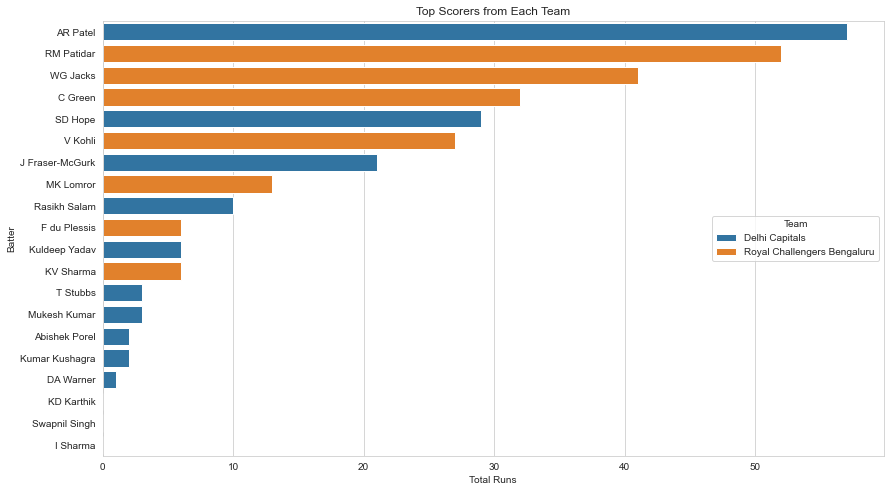

In [3]:
# Calculating top scorers for each team
top_scorers = deliveries_df.groupby(['team', 'batter']).agg({'runs_batter': 'sum'}).reset_index().sort_values(by = 'runs_batter', ascending = False)

plt.figure(figsize = (14,8))
sns.barplot(data = top_scorers, x = 'runs_batter', y = 'batter', hue = 'team', dodge = False)
plt.title('Top Scorers from Each Team')
plt.xlabel('Total Runs')
plt.ylabel('Batter')
plt.legend(title = 'Team', loc = 'center right')
plt.show()

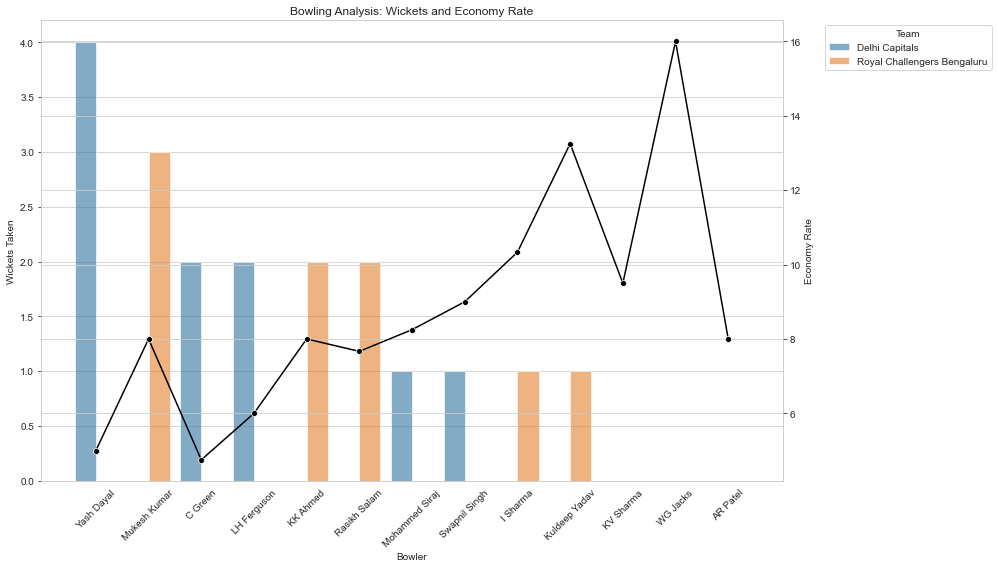

In [4]:
# Preparing data for bowling analysis
deliveries_df['wickets_taken'] = deliveries_df['wicket_kind'].notna().astype(int)
bowling_stats = deliveries_df.groupby(['team', 'bowler']).agg({'runs_total': 'sum', 'wickets_taken': 'sum', 'over': 'nunique'}).reset_index()

# Calculating economy rate (total runs coneded/number of overs bowled)
bowling_stats['economy_rate'] = bowling_stats['runs_total']/bowling_stats['over']

# Sorting the data for better visyalization
bowling_stats_sorted = bowling_stats.sort_values(by = 'wickets_taken', ascending = False)

# Prepare the DataFrame for plotting
bowling_stats_sorted['wickets_taken'] = deliveries_df['wicket_kind'].notna().astype(int)
bowling_stats = deliveries_df.groupby(['team', 'bowler']).agg({'runs_total': 'sum', 'wickets_taken': 'sum', 'over': 'nunique'}).reset_index()
bowling_stats['economy_rate'] = bowling_stats['runs_total']/bowling_stats['over']
bowling_stats_sorted = bowling_stats.sort_values(by = 'wickets_taken', ascending = False)

# Create the plot
fig, ax1 = plt.subplots(figsize = (14,8))

# Bar plot for wickets
sns.barplot(data = bowling_stats_sorted, x = 'bowler', y = 'wickets_taken', hue = 'team', ax=ax1, alpha = 0.6)
ax1.set_ylabel('Wickets Taken')
ax1.set_xlabel('Bowler')
ax1.set_title('Bowling Analysis: Wickets and Economy Rate')
ax1.legend(title = 'Team', bbox_to_anchor = (1.05,1), loc = 'upper left')

for item in ax1.get_xticklabels():
    item.set_rotation(45)
    
ax2 = ax1.twinx()
sns.lineplot(data = bowling_stats_sorted, x = 'bowler', y = 'economy_rate', marker = 'o', sort = False, ax=ax2, color = 'black')
ax2.set_ylabel('Economy Rate')

plt.tight_layout()
plt.show()


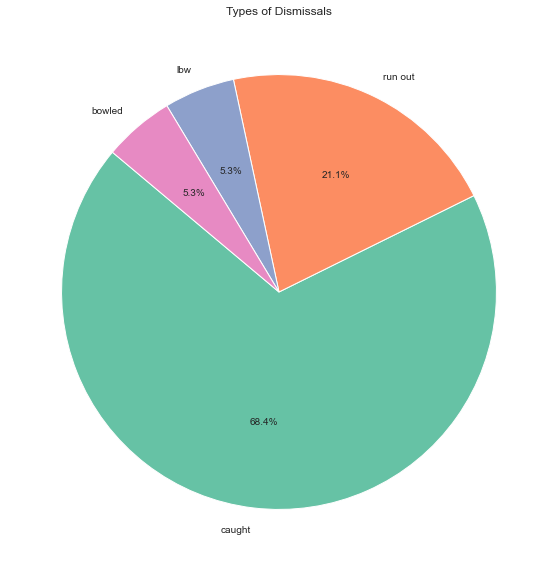

In [5]:
# Counting dismissal types
dismissal_types = deliveries_df['wicket_kind'].dropna().value_counts()

plt.figure(figsize = (10,10))
plt.pie(dismissal_types, labels = dismissal_types.index, autopct = '%1.1f%%', startangle = 140, colors = sns.color_palette("Set2"))
plt.title('Types of Dismissals')
plt.show()

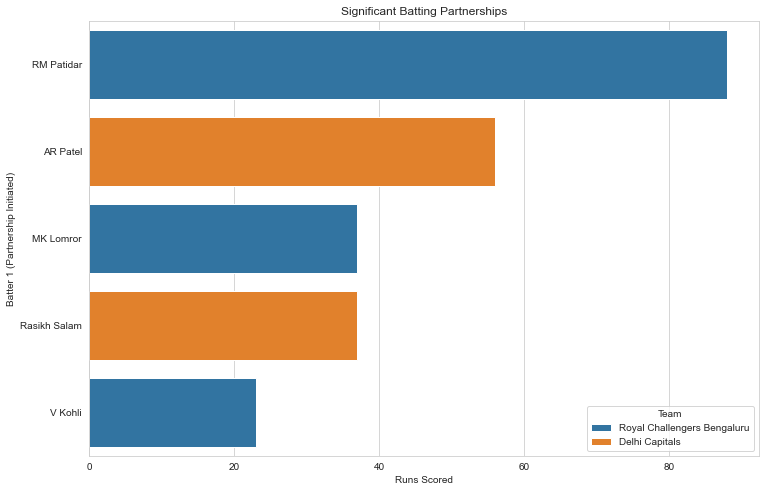

In [6]:
# Function to calculate partnerships
def calculating_partnerships(df):
    partnerships = []
    current_partnership = {}

    for i, row in df.iterrows():  # Fixed `interrows()`
        if i == 0 or (row['batter'] not in [current_partnership.get('batter1'), current_partnership.get('batter2')]):
            if current_partnership:
                partnerships.append(current_partnership)
            current_partnership = {
                'team': row['team'],
                'batter1': row['batter'],
                'batter2': row['non_striker'],
                'runs': 0,  # Fixed key 'run' -> 'runs'
                'balls': 0
            }

        current_partnership['runs'] += row['runs_total']
        current_partnership['balls'] += 1  # Fixed `currentpartnership['balls']`

        if 'player_out' in row and pd.notna(row['player_out']):
            partnerships.append(current_partnership)
            current_partnership = {}

    # Append the last partnership if not ended by a wicket
    if current_partnership:
        partnerships.append(current_partnership)

    return partnerships

# Calculating partnerships
partnerships_data = calculating_partnerships(deliveries_df)  # Fixed function name
partnership_df = pd.DataFrame(partnerships_data)

# Filter significant partnerships (more than 20 runs)
significant_partnerships = partnership_df[partnership_df['runs'] > 20]

# Sort by highest runs
significant_partnerships = significant_partnerships.sort_values(by='runs', ascending=False)

# Plot the significant partnerships
plt.figure(figsize=(12, 8))
sns.barplot(data=significant_partnerships, x='runs', y='batter1', hue='team', dodge=False)  # Fixed variable name
plt.title('Significant Batting Partnerships')
plt.xlabel('Runs Scored')
plt.ylabel('Batter 1 (Partnership Initiated)')
plt.legend(title='Team')
plt.show()
        

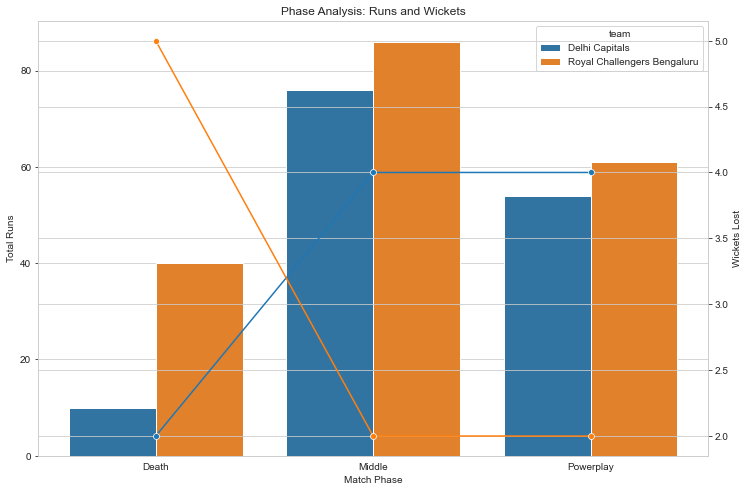

In [7]:
# function to classify the phase of the game based on the over number
def classify_phase(over):
    if over < 6:
        return 'Powerplay'
    elif over < 16:
        return 'Middle'
    else:
        return 'Death'

# adding phase information to the dataframe
deliveries_df['phase'] = deliveries_df['over'].apply(classify_phase)

# grouping data by phase and team to calculate runs and wickets
phase_analysis = deliveries_df.groupby(['team', 'phase']).agg({'runs_total': 'sum', 'wickets_taken': 'sum', 'over': 'count'}).rename(columns={'over': 'balls'}).reset_index()

# calculating the run rate
phase_analysis['run_rate'] = (phase_analysis['runs_total'] / phase_analysis['balls']) * 6

# plotting the phase analysis
fig, ax1 = plt.subplots(figsize=(12, 8))

# bar plot for runs scored in each phase
sns.barplot(data=phase_analysis, x='phase', y='runs_total', hue='team', ax=ax1)
ax1.set_title('Phase Analysis: Runs and Wickets')
ax1.set_ylabel('Total Runs')
ax1.set_xlabel('Match Phase')

# line plot for wickets lost
ax2 = ax1.twinx()
sns.lineplot(data=phase_analysis, x='phase', y='wickets_taken', hue='team', marker='o', ax=ax2, legend=False)
ax2.set_ylabel('Wickets Lost')

plt.show()

In [8]:
# Calculating runsand ballsfaced for each batter
batter_stats = deliveries_df.groupby('batter').agg({'runs_batter': 'sum', 'over': 'count'}).rename(columns = {'over': 'balls_faced'}).reset_index()

# Calculating strike rate for each batter (runs 100 balls)
batter_stats['strike_rate'] = (batter_stats['runs_batter']/batter_stats['balls_faced'])*100

# Sorting batterby their strike rate
batter_stats_sorted = batter_stats.sort_values(by = 'strike_rate', ascending = False)

# Displaying calculating strike rates along with run scored and balls faced 
batter_stats_sorted.head(20)

,batter,runs_batter,balls_faced,strike_rate
6,J Fraser-McGurk,21,8,262.500000
18,V Kohli,27,14,192.857143
13,RM Patidar,52,34,152.941176
8,KV Sharma,6,4,150.000000
0,AR Patel,57,40,142.500000
19,WG Jacks,41,30,136.666667
2,C Green,32,24,133.333333
11,MK Lomror,13,10,130.000000
15,SD Hope,29,24,120.833333
4,F du Plessis,6,7,85.714286


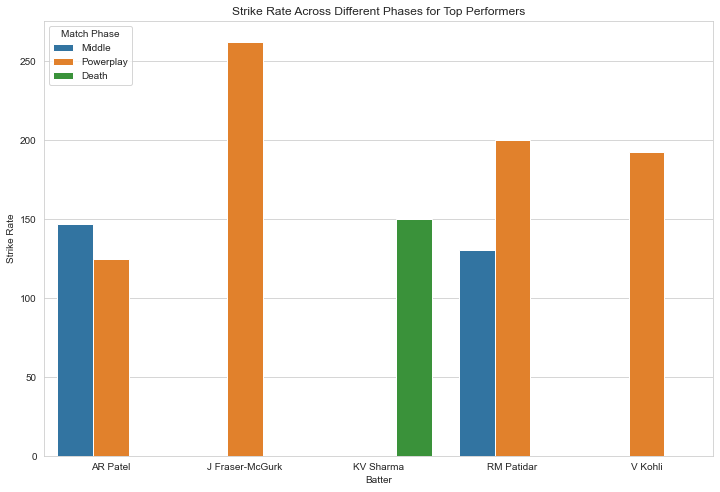

In [14]:
# merging phase information with batter stats
batter_phase_stats = deliveries_df.groupby(['batter', 'phase']).agg({'runs_batter': 'sum', 'over': 'count'}).rename(columns={'over': 'balls_faced'}).reset_index()

# calculate strike rate for each batter-phase combination
batter_phase_stats['strike_rate'] = (batter_phase_stats['runs_batter'] / batter_phase_stats['balls_faced']) * 100

# filtering for top performers based on overall strike rate
top_performers = batter_stats_sorted.head(5)['batter']
batter_phase_stats_top = batter_phase_stats[batter_phase_stats['batter'].isin(top_performers)]

# plotting strike rate across different phases for top performers
plt.figure(figsize=(12, 8))
sns.barplot(data=batter_phase_stats_top, x='batter', y='strike_rate', hue='phase')
plt.title('Strike Rate Across Different Phases for Top Performers')
plt.xlabel('Batter')
plt.ylabel('Strike Rate')
plt.legend(title='Match Phase')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


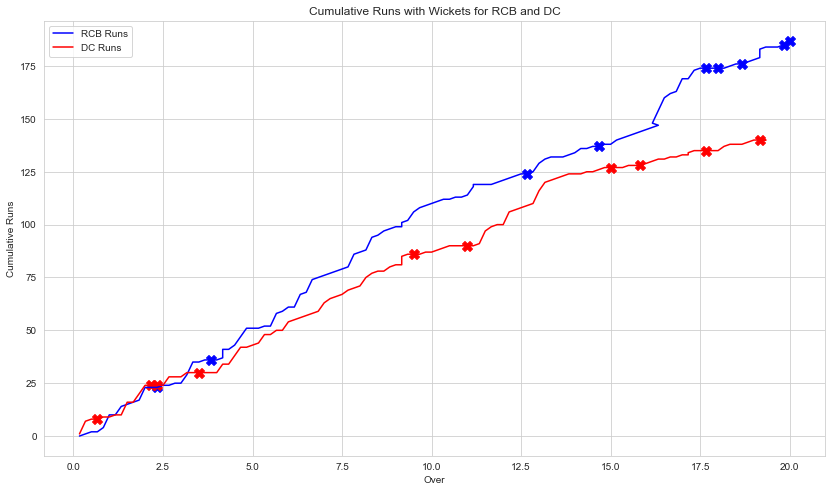

In [15]:
# calculate cumulative runs and wickets for each ball for both teams
deliveries_df['cumulative_runs'] = deliveries_df.groupby('team')['runs_total'].cumsum()
deliveries_df['cumulative_wickets'] = deliveries_df.groupby('team')['wickets_taken'].cumsum()

# separate data for both teams
rcb_deliveries = deliveries_df[deliveries_df['team'] == 'Royal Challengers Bengaluru']
dc_deliveries = deliveries_df[deliveries_df['team'] == 'Delhi Capitals']

# calculating overs for cumulative analysis
rcb_deliveries['over_ball'] = rcb_deliveries['over'] + (rcb_deliveries.groupby('over').cumcount() + 1) / 6
dc_deliveries['over_ball'] = dc_deliveries['over'] + (dc_deliveries.groupby('over').cumcount() + 1) / 6

# plotting cumulative run rates and wickets
fig, ax = plt.subplots(figsize=(14, 8))

# plot for RCB
ax.plot(rcb_deliveries['over_ball'], rcb_deliveries['cumulative_runs'], color='blue', label='RCB Runs')
ax.scatter(rcb_deliveries[rcb_deliveries['wickets_taken'] == 1]['over_ball'], rcb_deliveries[rcb_deliveries['wickets_taken'] == 1]['cumulative_runs'], color='blue', marker='X', s=100)

# plot for DC
ax.plot(dc_deliveries['over_ball'], dc_deliveries['cumulative_runs'], color='red', label='DC Runs')
ax.scatter(dc_deliveries[dc_deliveries['wickets_taken'] == 1]['over_ball'], dc_deliveries[dc_deliveries['wickets_taken'] == 1]['cumulative_runs'], color='red', marker='X', s=100)

ax.set_title('Cumulative Runs with Wickets for RCB and DC')
ax.set_xlabel('Over')
ax.set_ylabel('Cumulative Runs')
ax.legend()
plt.show()

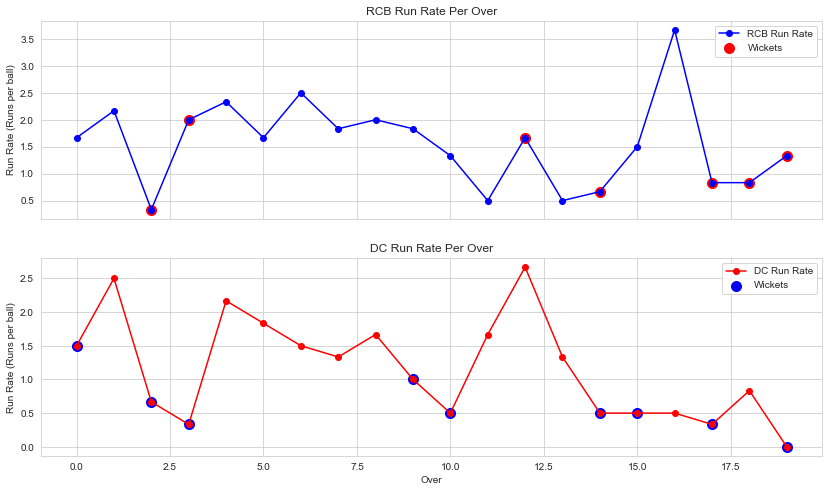

In [16]:
# calculate runs and wickets per over for both teams
per_over_stats = deliveries_df.groupby(['team', 'over']).agg({'runs_total': 'sum', 'wickets_taken': 'sum'}).reset_index()

# calculate run rate for each over
per_over_stats['run_rate'] = (per_over_stats['runs_total'] / 6)    # Runs per over to runs per ball (standard rate)

# separate data for RCB and DC for plotting
rcb_per_over_stats = per_over_stats[per_over_stats['team'] == 'Royal Challengers Bengaluru']
dc_per_over_stats = per_over_stats[per_over_stats['team'] == 'Delhi Capitals']

# plotting run rates and marking wickets for each team
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# RCB
ax1.plot(rcb_per_over_stats['over'], rcb_per_over_stats['run_rate'], marker='o', color='blue', label='RCB Run Rate')
ax1.scatter(rcb_per_over_stats[rcb_per_over_stats['wickets_taken'] > 0]['over'], rcb_per_over_stats[rcb_per_over_stats['wickets_taken'] > 0]['run_rate'], color='red', s=100, label='Wickets')
ax1.set_title('RCB Run Rate Per Over')
ax1.set_ylabel('Run Rate (Runs per ball)')
ax1.legend()

# DC
ax2.plot(dc_per_over_stats['over'], dc_per_over_stats['run_rate'], marker='o', color='red', label='DC Run Rate')
ax2.scatter(dc_per_over_stats[dc_per_over_stats['wickets_taken'] > 0]['over'], dc_per_over_stats[dc_per_over_stats['wickets_taken'] > 0]['run_rate'], color='blue', s=100, label='Wickets')
ax2.set_title('DC Run Rate Per Over')
ax2.set_xlabel('Over')
ax2.set_ylabel('Run Rate (Runs per ball)')
ax2.legend()

plt.show()